<a href="https://colab.research.google.com/github/stevengregori92/CNN-Intro/blob/main/CNN_with_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install luwiji
!pip install "jcopdl<2.0"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 MB 21.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 67.3 MB/s eta 0:00:00
  Created wheel for luwiji: filename=luwiji-1.2.1-py2.py3-none-any.whl size=40366830 sha256=a09d07be44084075ff20878f2b29d4cd815ebf83ebafd3f4027aa88d4069c7e1
  Stored in directory: /root/.cache/pip/wheels/ba/90/9e/943ac5067e9cdc185d8f029a1d13278acd52839118acc06c9a
  Created wheel for jcopml: filename=jcopml-1.2.2-py2.py3-none-any.whl size=32178 sha256=e47798aafffba21412e211e702990e284bcc536a6fb2a0ead4826498560aaa7a
  Stored in directory: /root/.cache/pip/wheels/5e/06/58/749e5f1baf2932285758798a92793d4347888826160b025808
Successfully built luwiji jcopml
Looking in indexes: 

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import torch
from torch import nn, optim
from jcopdl.callback import Callback, set_config

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

#Dataset & Dataloader

In [4]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [26]:
bs=128
crop_size = 64

train_transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(crop_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(70),
    transforms.CenterCrop(crop_size),
    transforms.ToTensor()
])

train_set = datasets.ImageFolder('drive/MyDrive/CNN_Data/train', transform=train_transform)
trainloader = DataLoader(train_set, batch_size=bs, shuffle = True, num_workers=4)

test_set = datasets. ImageFolder('drive/MyDrive/CNN_Data/train', transform=test_transform)
testloader = DataLoader(test_set, batch_size=bs, shuffle = True)

In [27]:
feature, labels = next(iter(trainloader))
feature.shape

torch.Size([128, 3, 64, 64])

In [28]:
label2cat = train_set.classes
label2cat

['invasive', 'noninvasive']

#Arsitektur dan Config

In [29]:
from jcopdl.layers import conv_block, linear_block

In [30]:
nn.Conv2d(3,8,3,1,1)

Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [31]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv=nn.Sequential(
        conv_block(3, 8),
        conv_block(8, 16),
        conv_block(16, 32),
        conv_block(32, 64),
        nn.Flatten()
    )
    self.fc = nn.Sequential(
        linear_block(1024, 256, dropout=0.1),
        linear_block(256, 2, activation='lsoftmax')
    )

  def forward(self, x):
    x = self.conv(x)
    x = self.fc(x)
    return x

In [32]:
config = set_config({
    'batch_size': bs,
    'crop_size': crop_size
})

#Training Prepareation

In [33]:
model = CNN().to(device)
criterion = nn.NLLLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)
callback = Callback(model, config, outdir='model')

#Training

In [34]:
from tqdm.auto import tqdm

def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
    if mode == 'train':
        model.train()
    elif mode == 'test':
        model.eval()
    cost = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device) # corrected line
        output = model(feature)
        loss = criterion(output, target)

        if mode == 'train':
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        cost += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
        
    cost = cost/len(dataset)
    acc = correct/len(dataset)
    return cost, acc

Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch     1
Train_cost  = 0.6931 | Test_cost  = 0.6855 | Train_score = 0.5030 | Test_score = 0.5210 |


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa417bdd750>Exception ignored in: 


Train:   0%|          | 0/8 [00:00<?, ?it/s]

<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa417bdd750>Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
        self._shutdown_workers()Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa417bdd750>self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers


      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
if w.is_alive():    Traceback (most recent call last):

if w.is_alive():  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

  File "/usr/lib/py

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch     2
Train_cost  = 0.6760 | Test_cost  = 0.6372 | Train_score = 0.5870 | Test_score = 0.7130 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch     3
Train_cost  = 0.5984 | Test_cost  = 0.6313 | Train_score = 0.7060 | Test_score = 0.6460 |
==> EarlyStop patience =  1 | Best test_score: 0.7130


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch     4
Train_cost  = 0.5830 | Test_cost  = 0.5682 | Train_score = 0.6980 | Test_score = 0.7320 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch     5
Train_cost  = 0.5466 | Test_cost  = 0.5315 | Train_score = 0.7330 | Test_score = 0.7310 |
==> EarlyStop patience =  1 | Best test_score: 0.7320


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch     6
Train_cost  = 0.5057 | Test_cost  = 0.4724 | Train_score = 0.7410 | Test_score = 0.8020 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa417bdd750>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
Exception ignored in:     : assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionErrorcan only test a child process
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa417bdd750>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch     7
Train_cost  = 0.4607 | Test_cost  = 0.4190 | Train_score = 0.7900 | Test_score = 0.8100 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch     8
Train_cost  = 0.4142 | Test_cost  = 0.3884 | Train_score = 0.8110 | Test_score = 0.8290 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch     9
Train_cost  = 0.4055 | Test_cost  = 0.3983 | Train_score = 0.8150 | Test_score = 0.8300 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    10
Train_cost  = 0.4080 | Test_cost  = 0.3863 | Train_score = 0.8150 | Test_score = 0.8280 |
==> EarlyStop patience =  1 | Best test_score: 0.8300


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    11
Train_cost  = 0.3698 | Test_cost  = 0.3632 | Train_score = 0.8440 | Test_score = 0.8400 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa417bdd750>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa417bdd750>
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

    if w.is_alive():Traceback (most recent call last):

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
AssertionError
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
: can only test a child processException ignored in: <function _MultiP

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    12
Train_cost  = 0.3696 | Test_cost  = 0.3561 | Train_score = 0.8370 | Test_score = 0.8440 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    13
Train_cost  = 0.3708 | Test_cost  = 0.3812 | Train_score = 0.8380 | Test_score = 0.8300 |
==> EarlyStop patience =  1 | Best test_score: 0.8440


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    14
Train_cost  = 0.3479 | Test_cost  = 0.3680 | Train_score = 0.8440 | Test_score = 0.8350 |
==> EarlyStop patience =  2 | Best test_score: 0.8440


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    15
Train_cost  = 0.3564 | Test_cost  = 0.3377 | Train_score = 0.8440 | Test_score = 0.8500 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    16
Train_cost  = 0.3532 | Test_cost  = 0.3764 | Train_score = 0.8420 | Test_score = 0.8320 |
==> EarlyStop patience =  1 | Best test_score: 0.8500


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa417bdd750>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa417bdd750>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

    Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
self._shutdown_workers()    
if w.is_alive():  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
if w.is_alive():    
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
assert self._parent_pid == os.getpid(), 'can only test a

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    17
Train_cost  = 0.3446 | Test_cost  = 0.3303 | Train_score = 0.8540 | Test_score = 0.8550 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    18
Train_cost  = 0.3356 | Test_cost  = 0.3421 | Train_score = 0.8630 | Test_score = 0.8490 |
==> EarlyStop patience =  1 | Best test_score: 0.8550


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    19
Train_cost  = 0.3320 | Test_cost  = 0.3354 | Train_score = 0.8560 | Test_score = 0.8560 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    20
Train_cost  = 0.3362 | Test_cost  = 0.3328 | Train_score = 0.8550 | Test_score = 0.8560 |


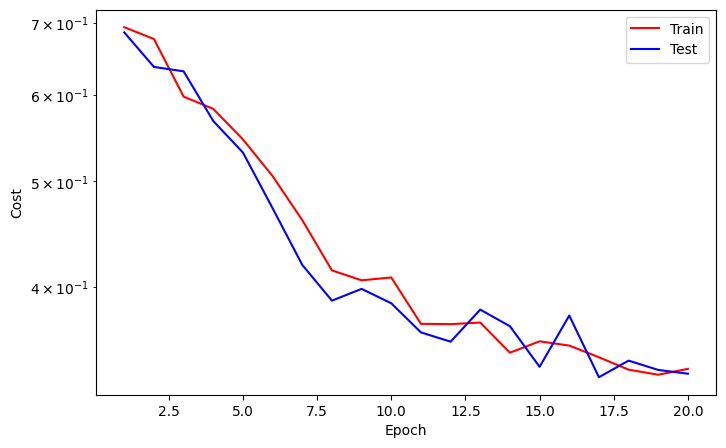

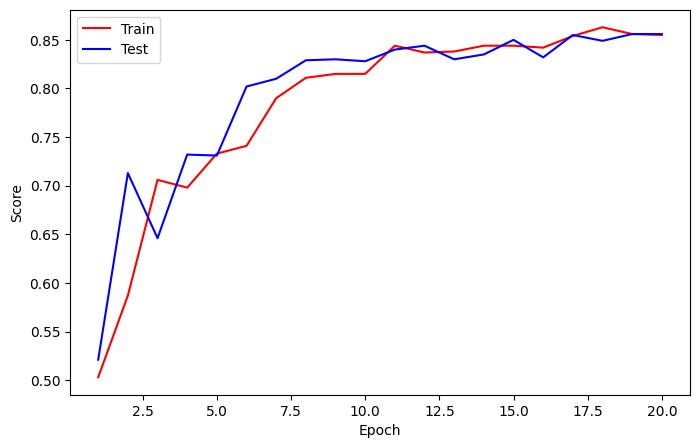

==> EarlyStop patience =  1 | Best test_score: 0.8560


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    21
Train_cost  = 0.3231 | Test_cost  = 0.3233 | Train_score = 0.8550 | Test_score = 0.8560 |
==> EarlyStop patience =  2 | Best test_score: 0.8560


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    22
Train_cost  = 0.3162 | Test_cost  = 0.3094 | Train_score = 0.8670 | Test_score = 0.8640 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    23
Train_cost  = 0.3183 | Test_cost  = 0.3113 | Train_score = 0.8610 | Test_score = 0.8650 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    24
Train_cost  = 0.2961 | Test_cost  = 0.3159 | Train_score = 0.8790 | Test_score = 0.8650 |
==> EarlyStop patience =  1 | Best test_score: 0.8650


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    25
Train_cost  = 0.3115 | Test_cost  = 0.3071 | Train_score = 0.8690 | Test_score = 0.8710 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa417bdd750>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()Exception ignored in: 
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa417bdd750>Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa417bdd750>Traceback (most recent call last):
    
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
if w.is_alive():Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

self._shutdown_workers()  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        assert self._parent_pid == os.getpid()

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    26
Train_cost  = 0.3110 | Test_cost  = 0.2956 | Train_score = 0.8750 | Test_score = 0.8750 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    27
Train_cost  = 0.2812 | Test_cost  = 0.3424 | Train_score = 0.8870 | Test_score = 0.8520 |
==> EarlyStop patience =  1 | Best test_score: 0.8750


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    28
Train_cost  = 0.2889 | Test_cost  = 0.2855 | Train_score = 0.8780 | Test_score = 0.8830 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    29
Train_cost  = 0.2885 | Test_cost  = 0.2858 | Train_score = 0.8820 | Test_score = 0.8810 |
==> EarlyStop patience =  1 | Best test_score: 0.8830


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa417bdd750>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Exception ignored in:     self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa417bdd750>

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
        if w.is_alive():self._shutdown_workers()

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
        if w.is_alive():
assert self._parent_pid == os.getpid(), 'can only test a child process'
  File "/usr/lib/python3.10/multiprocessing/process.py", line 1

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    30
Train_cost  = 0.2799 | Test_cost  = 0.3057 | Train_score = 0.8840 | Test_score = 0.8700 |
==> EarlyStop patience =  2 | Best test_score: 0.8830


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    31
Train_cost  = 0.2824 | Test_cost  = 0.2807 | Train_score = 0.8780 | Test_score = 0.8880 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    32
Train_cost  = 0.2845 | Test_cost  = 0.2927 | Train_score = 0.8830 | Test_score = 0.8760 |
==> EarlyStop patience =  1 | Best test_score: 0.8880


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    33
Train_cost  = 0.3056 | Test_cost  = 0.3128 | Train_score = 0.8680 | Test_score = 0.8690 |
==> EarlyStop patience =  2 | Best test_score: 0.8880


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    34
Train_cost  = 0.2942 | Test_cost  = 0.2818 | Train_score = 0.8810 | Test_score = 0.8870 |
==> EarlyStop patience =  3 | Best test_score: 0.8880


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa417bdd750>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionErrorException ignored in: : <function _MultiProcessingDataLoaderIter.__del__ at 0x7fa417bdd750>can only test a child process

Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fa417bdd750>    
self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/pyt

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    35
Train_cost  = 0.2757 | Test_cost  = 0.2674 | Train_score = 0.8850 | Test_score = 0.8950 |


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    36
Train_cost  = 0.2644 | Test_cost  = 0.2750 | Train_score = 0.8980 | Test_score = 0.8820 |
==> EarlyStop patience =  1 | Best test_score: 0.8950


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    37
Train_cost  = 0.2625 | Test_cost  = 0.2666 | Train_score = 0.8850 | Test_score = 0.8830 |
==> EarlyStop patience =  2 | Best test_score: 0.8950


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    38
Train_cost  = 0.2961 | Test_cost  = 0.2677 | Train_score = 0.8770 | Test_score = 0.8930 |
==> EarlyStop patience =  3 | Best test_score: 0.8950


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    39
Train_cost  = 0.2688 | Test_cost  = 0.3132 | Train_score = 0.8910 | Test_score = 0.8650 |
==> EarlyStop patience =  4 | Best test_score: 0.8950


Train:   0%|          | 0/8 [00:00<?, ?it/s]

Test:   0%|          | 0/8 [00:00<?, ?it/s]


Epoch    40
Train_cost  = 0.2837 | Test_cost  = 0.3203 | Train_score = 0.8890 | Test_score = 0.8660 |


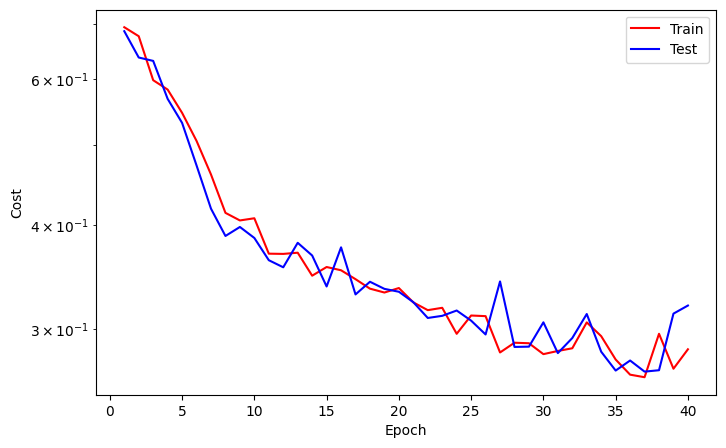

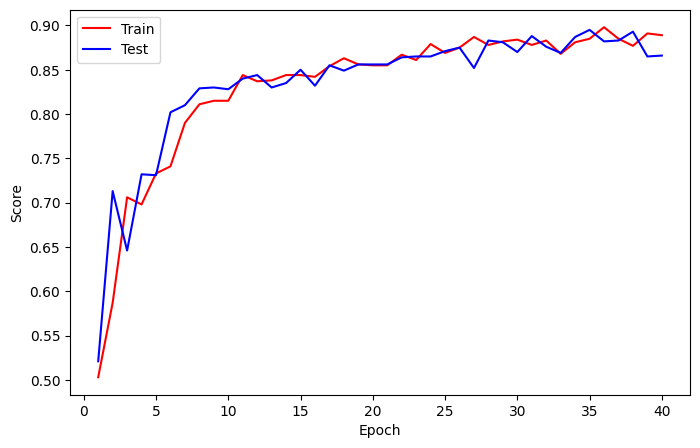

==> EarlyStop patience =  5 | Best test_score: 0.8950
==> Execute Early Stopping at epoch: 40 | Best test_score: 0.8950
==> Best model is saved at model


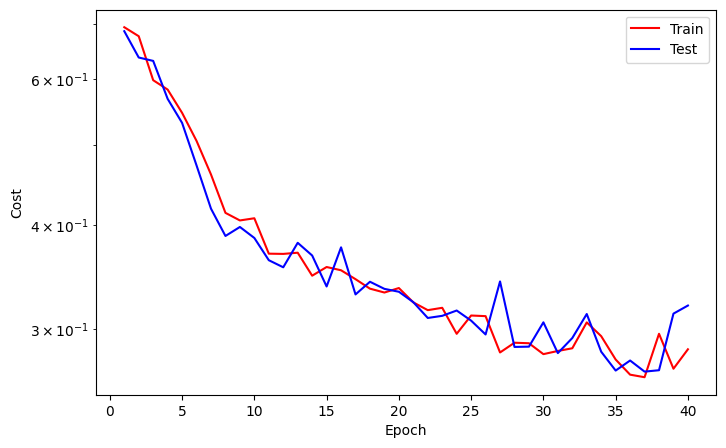

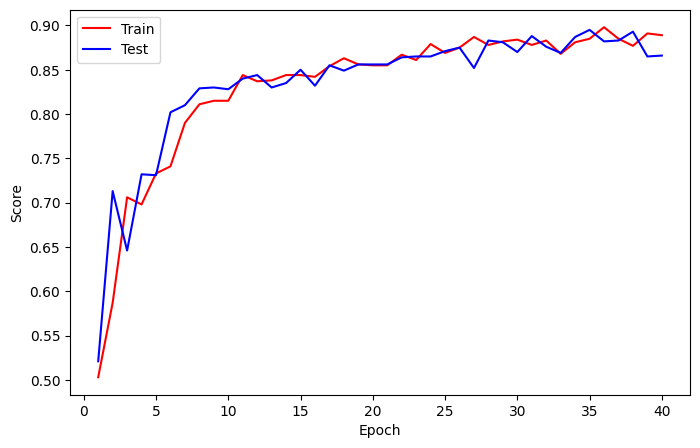

In [35]:
while True:
  train_cost, train_score = loop_fn('train', train_set, trainloader, model, criterion, optimizer, device)
  with torch.no_grad():
      test_cost, test_score = loop_fn('test', test_set, testloader, model, criterion, optimizer, device)

  #Logging
  callback.log(train_cost, test_cost, train_score, test_score)

  #Checkpoint
  callback.save_checkpoint()

  #Runtime Plotting
  callback.cost_runtime_plotting()
  callback.score_runtime_plotting()

  #Early Stopping
  if callback.early_stopping(model, monitor='test_score'):
    callback.plot_cost()
    callback.plot_score()
    break

#Predict

In [36]:
feature, target = next(iter(testloader))
feature, target = feature.to(device), target.to(device)

In [38]:
with torch.no_grad():
  model.eval()
  output = model(feature)
  preds = output.argmax(1)
preds

tensor([0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0,
        1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
        0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0,
        0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
        0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1,
        1, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')

#Visualize

In [39]:
import matplotlib.pyplot as plt

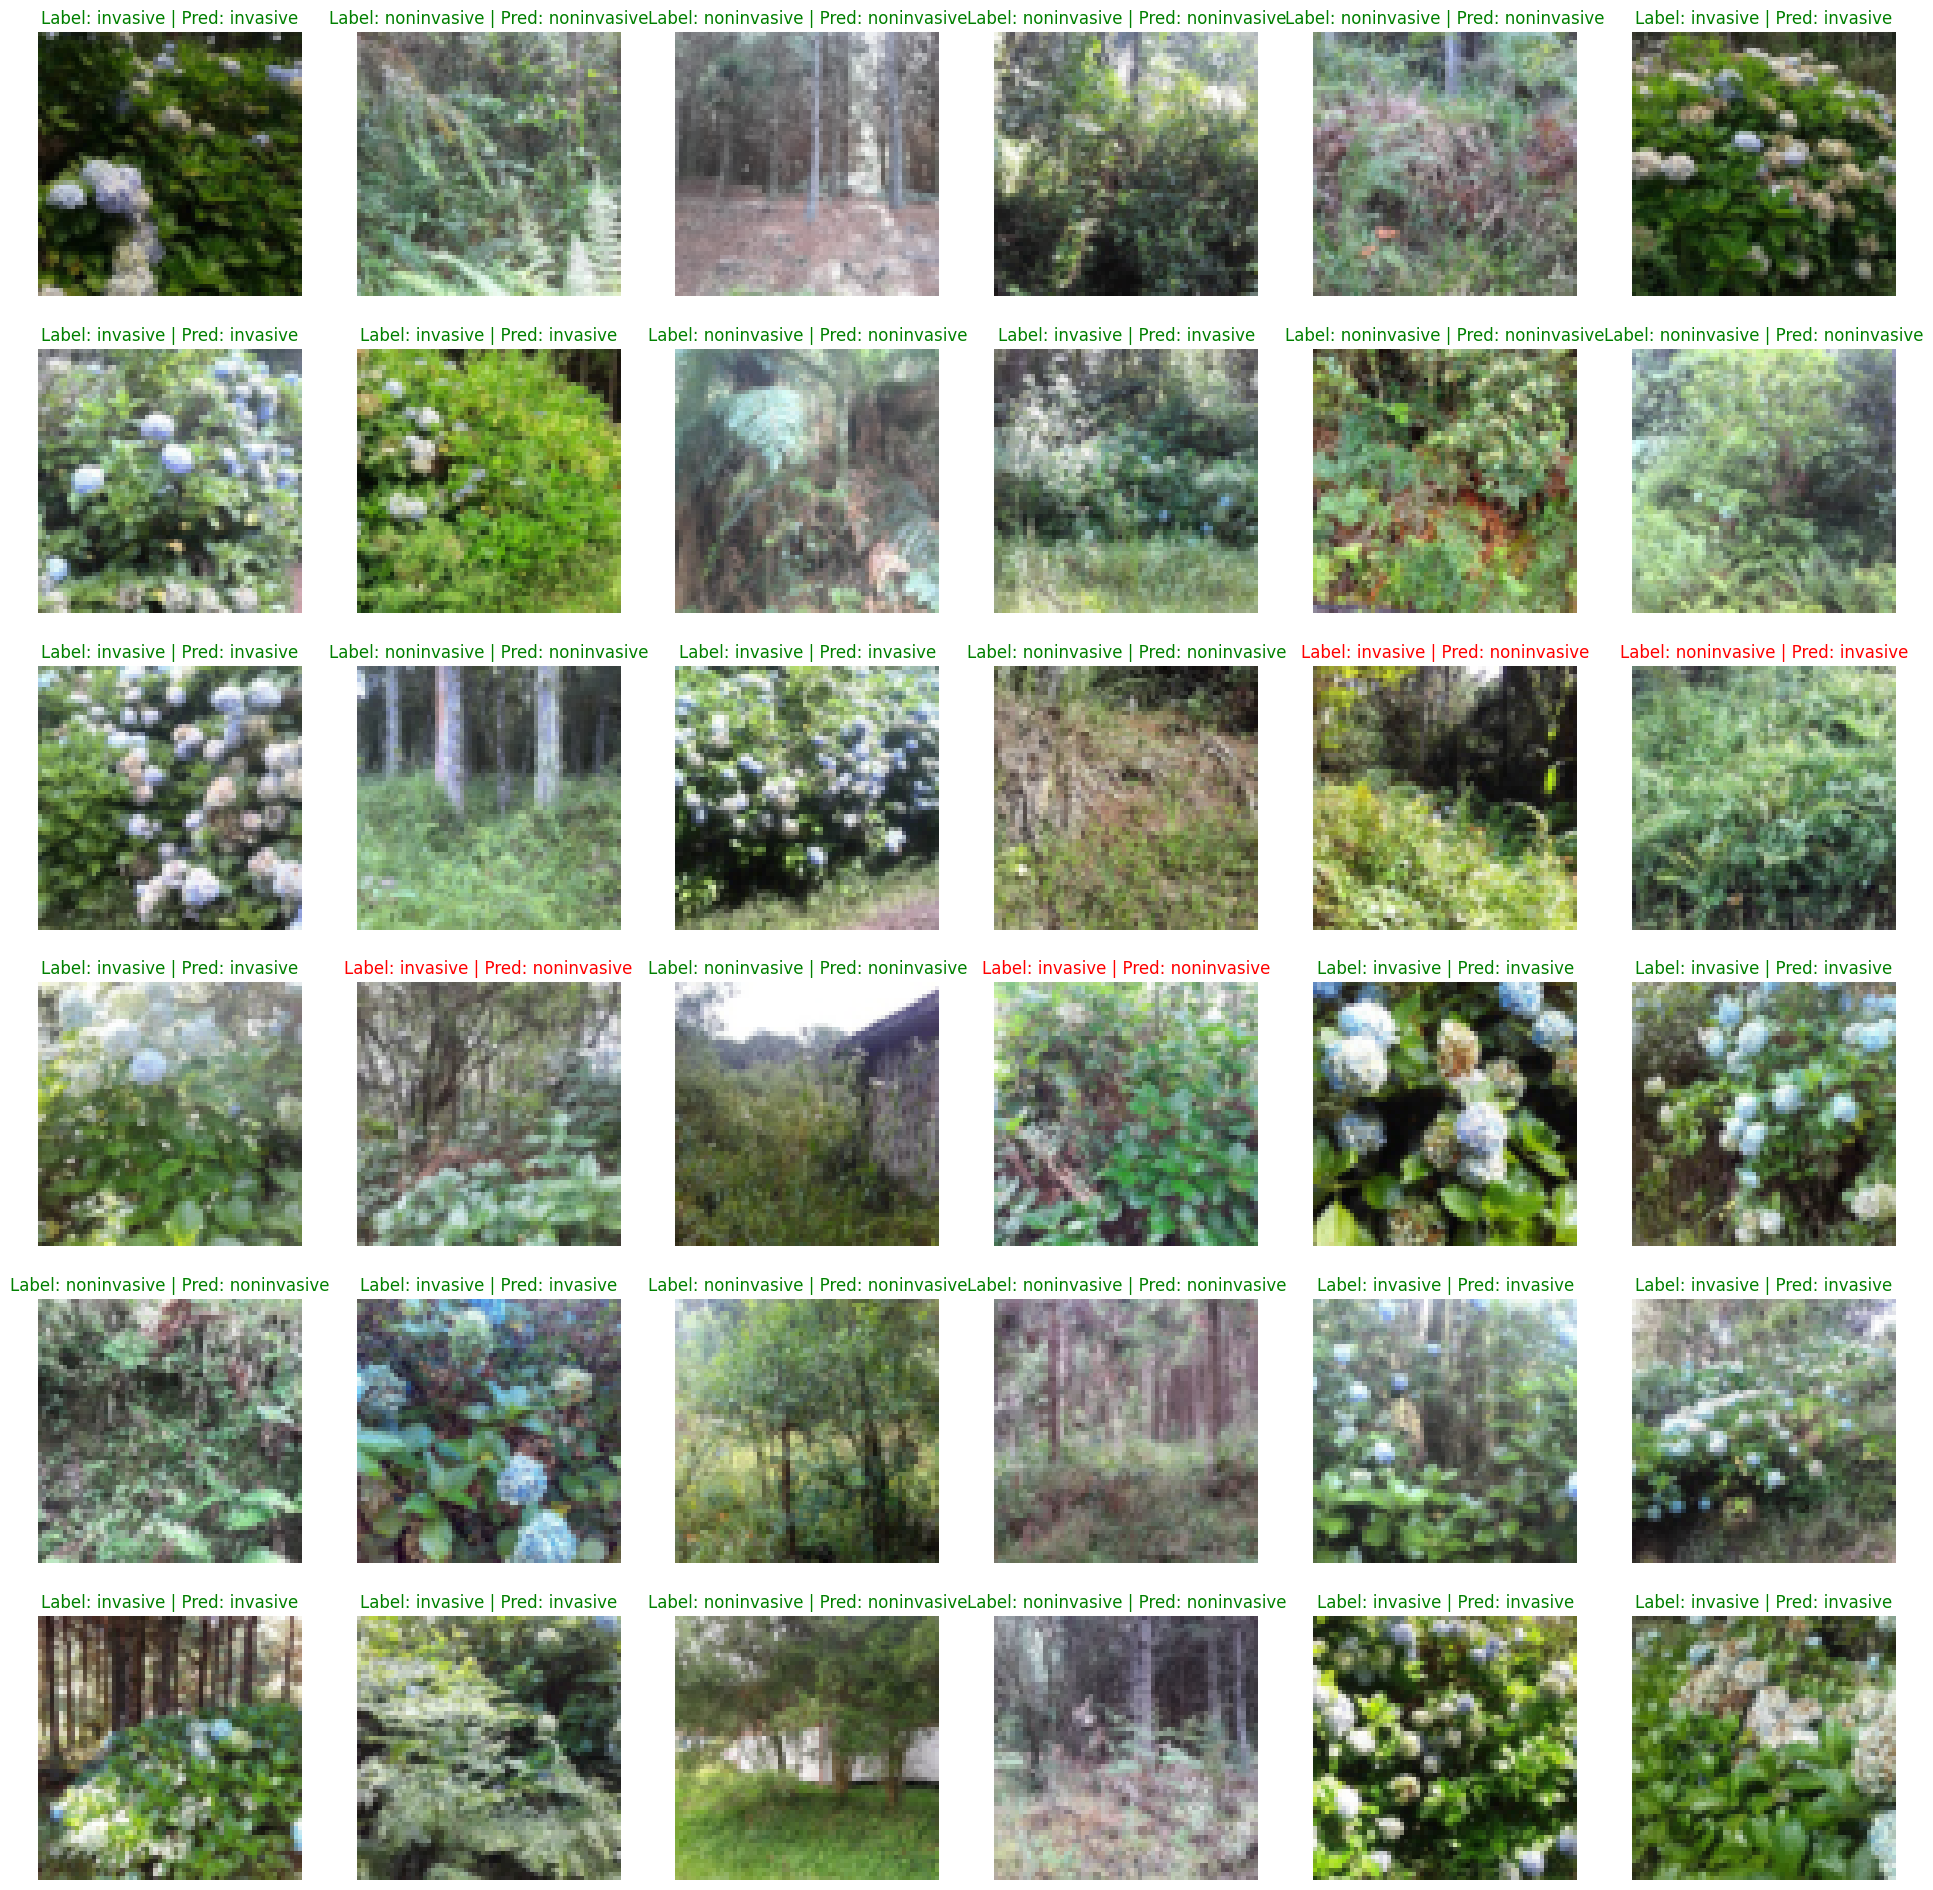

In [47]:
fig, axes = plt.subplots(6, 6, figsize=(24, 24))
for image, label, pred, ax in zip(feature, target, preds, axes.flatten()):
    ax.imshow(image.permute(1, 2, 0).cpu())
    font = {'color': 'r'} if label.item() != pred.item() else {'color': 'g'}
    label, pred = label2cat[label.item()], label2cat[pred.item()]
    ax.set_title(f'Label: {label} | Pred: {pred}', fontdict=font)
    ax.axis('off')

plt.show()
